In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
df_ref = pd.read_parquet("P:/Projets Internes/PLADIFES/PLADIFES DATA CREATION/full_extract_refinitiv_2307.parquet")

In [3]:
df_ref.columns

Index(['FinalEikonID', 'Name', 'CUSIP', 'ISIN', 'Ticker', 'LEI',
       'OrganizationID', 'CountryHQ', 'NAICSSector', 'NAICSInd', 'GICSSector',
       'GICSGroup', 'GICSInd', 'GICSSubInd', 'GICSName', 'FiscalYear', 'CF1',
       'CF2', 'CF3', 'CFE', 'EstMethod', 'EBITDA', 'EBIT', 'CapEx', 'GPPE',
       'NPPE', 'AccuDep', 'INTAN', 'COGS', 'GMAR', 'Asset', 'LTDebt', 'EMP',
       'ENEProduce', 'ENEConsume', 'WasteTotal', 'WasteRecycledTotal',
       'NonHazardousWaste', 'HazardousWaste', 'WaterWithdrawalTotal',
       'FreshWaterWithdrawalTotal', 'WaterRecycled', 'TargetsEmissions',
       'PolicyEmissions', 'BiodiversityImpactReduction', 'EnvExpenditures',
       'EnvProvisions', 'EnvInvestments', 'RenewEnergyUse',
       'RenewEnergyPurchased', 'RenewEnergyProduced', 'TrainingHoursTotal',
       'GenderPayGapPctage', 'AnalyticIndepBoard',
       'AnalyticHighestRemuneration', 'Revenue', 'CF123'],
      dtype='object')

In [ ]:
# Checks
# df_ref.CF3.min() no CF1, 2 3 < 0

In [8]:
# We do not trust companies with null scope 2 and 3 
df_ref["CF2"] = df_ref["CF2"].replace(0, np.nan)
df_ref["CF3"] = df_ref["CF3"].replace(0, np.nan)

In [9]:
df_ref[df_ref.GICSSubInd.isna()].shape  # 6463 companies have no sub sectors but :  
df_ref[df_ref.CF3.notna()][df_ref.GICSSubInd.isna()].shape # check all have sub  sectors : ok

C:\Users\thibaud.barreau\AppData\Local\Temp\ipykernel_15444\3289117754.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ref[df_ref.CF3.notna()][df_ref.GICSSubInd.isna()].shape # check all have sub  sectors : ok


(0, 57)

In [11]:
# companie specific adjustments

# df_ref.loc[df_ref.Name == "Elmera Group ASA", "CF1"] = [10.7, 14.7, 15, 0.1]+ [np.nan for i in range(19)]
# df_ref.loc[df_ref.Name == "Elmera Group ASA", "CF2"] = [0.1, 0.1, 0.1, 0.1] + [np.nan for i in range(19)]
# df_ref.loc[df_ref.Name == "Elmera Group ASA", "CF3"] = [263.5, 79.9, 102, 300.1] + [np.nan for i in range(19)]
# df_ref.loc[df_ref.Name == "Elmera Group ASA", "CF123"] = [274.2, 94.6, 117, 300.3] +  [np.nan for i in range(19)]

# Potential errors detection

In [12]:
df_ref_temp = df_ref[df_ref.FiscalYear >= 2005]
df_ref_temp = df_ref_temp[(df_ref_temp.CF1.notna()) | (df_ref_temp.CF2.notna()) | (df_ref_temp.CF3.notna())] 
df_ref_temp.FinalEikonID.nunique() # 6029 companies can be used for ML pipeline

6029

In [13]:
subind_coverage = df_ref_temp.drop_duplicates("FinalEikonID").GICSName.value_counts()
under_represented_sectors = subind_coverage[subind_coverage < 10].index

country_coverage = df_ref_temp.drop_duplicates("FinalEikonID").CountryHQ.value_counts()
under_represented_countries = country_coverage[country_coverage < 10].index

suspicious corpo CF1 :  29


<AxesSubplot: >

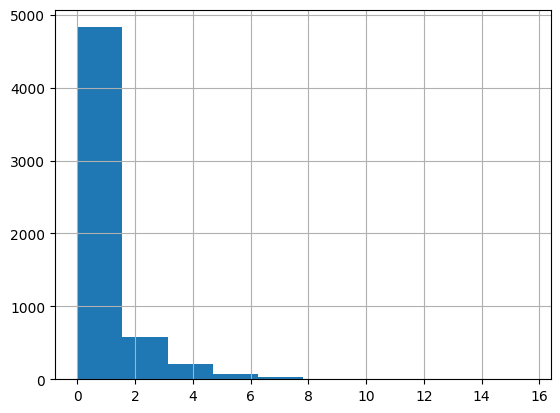

In [14]:
scope= "CF1"
df_ref_temp_scope = df_ref_temp[df_ref_temp[scope]>1]

spreads = df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())
acc_suspicious_CF1 = df_ref[df_ref.FinalEikonID.isin(spreads[spreads>1000].index)].FinalEikonID # outliers after 7 on plot, exp(7) = 1000, 
print("suspicious corpo CF1 : ",acc_suspicious_CF1.nunique())
np.log(df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())).hist()

suspicious corpo CF2 :  42


<AxesSubplot: >

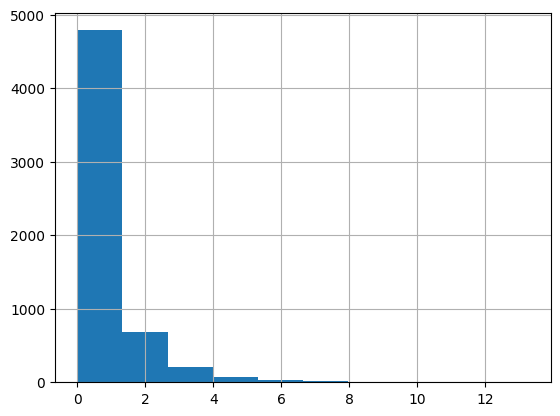

In [15]:
scope= "CF2"
df_ref_temp_scope = df_ref_temp[df_ref_temp[scope]>1]

spreads = df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())
acc_suspicious_CF2 = df_ref[df_ref.FinalEikonID.isin(spreads[spreads>500].index)].FinalEikonID # outliers after 6 on plot, exp(6) = 500, 
print("suspicious corpo CF2 : ",acc_suspicious_CF2.nunique())
np.log(df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())).hist()

suspicious corpo CF3 :  150


<AxesSubplot: >

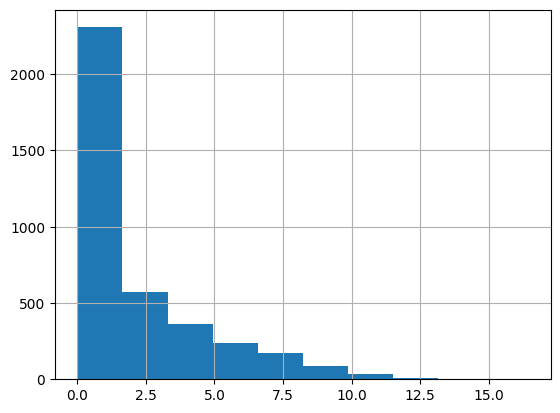

In [16]:
scope= "CF3"
df_ref_temp_scope = df_ref_temp[df_ref_temp[scope]>1]

spreads = df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())
acc_suspicious_CF3 = df_ref[df_ref.FinalEikonID.isin(spreads[spreads>3000].index)].FinalEikonID # outliers after 8 on plot, exp(8) = 3000, 
print("suspicious corpo CF3 : ",acc_suspicious_CF3.nunique())
np.log(df_ref_temp_scope.groupby("FinalEikonID")[scope].agg(lambda x : x.max()/x.min())).hist()

In [17]:
suspicious_corpo = list(set(acc_suspicious_CF1.unique()).union(set(acc_suspicious_CF2.unique()).union(set(acc_suspicious_CF3.unique()))))
len(suspicious_corpo)
# We have 6029 companies with not all na scopes, and 211 (3.5%) as potential outliers
# 5 are in underrepresented countries/sectors, thus we will investigate these only

211

In [18]:
df_supicious = df_ref_temp[df_ref_temp.FinalEikonID.isin(suspicious_corpo)]
df_supicious[df_supicious.CountryHQ.isin(under_represented_countries)].FinalEikonID.unique()

<StringArray>
['MELI.OQ', 'MABK.KW', 'KETL.L']
Length: 3, dtype: string

In [19]:
df_supicious[df_supicious.GICSName.isin(under_represented_sectors)].FinalEikonID.unique()

<StringArray>
['7272.T', 'MMC.N']
Length: 2, dtype: string

In [20]:
df_supicious = df_supicious[~(df_supicious.CountryHQ.isin(under_represented_countries))]
df_supicious = df_supicious[~(df_supicious.GICSName.isin(under_represented_sectors))]
df_supicious.Name.nunique()

206

In [212]:
# df_ref_temp[df_ref_temp.FinalEikonID == '7272.T'][["Name", "FiscalYear","CF1", "CF2", "CF3", "Revenue", "GICSName", "CountryHQ"]]

In [21]:
# MELI.OQ ok (https://meli-sustentabilidad-assets.s3.sa-east-1.amazonaws.com/MELI_Reporte_2016_ENG_a2856490bf.pdf, https://api.mziq.com/mzfilemanager/v2/d/098a2d95-0ea8-4ed5-a340-d9ef6a2b0053/0310ee3c-bd97-4ee1-8429-41cbf3cb1675?origin=2)
# MABK.KW 2022 ok but other scope 3 not relevant (replace na) (https://www.mabanee.com/home/CSR/Sustainability-Annual-Reports)
# KETL.L 2022 et 2021 ok but other scope 3 not relevant (replace na) (https://strix.com/docs/2023/img_38aca2998c.pdf)
# 7272.T CF3 : faux avant 2016 et pas dans les RA, replace NA (https://global.yamaha-motor.com/ir/integrated-report/annual2015/pdf/2015annual_csr_e.pdf)
# MMC.N  pas trouver data avant 2014, remove CF1 2011 10 09 (https://news-investors.mmc.com/static-files/510700ae-16d1-429c-a0c3-618d96ba42b1 https://www.marshmclennan.com/content/dam/mmc-web/v3/esg-report-2022/Marsh-McLennan-2022-ESG-Report.pdf)

df_ref.loc[df_ref[df_ref.FinalEikonID == 'MABK.KW'].index,"CF3"] = [119164.40] + [np.nan for i in range(22)] 
df_ref.loc[df_ref[df_ref.FinalEikonID == 'KETL.L'].index,"CF1"] = [273, 265, 107, 1879, 173, 163] + [np.nan for i in range(17)] 
df_ref.loc[df_ref[df_ref.FinalEikonID == 'KETL.L'].index,"CF2"] = [5883, 7430, 5269, 5912, 5791, 6162] + [np.nan for i in range(17)] 
df_ref.loc[df_ref[df_ref.FinalEikonID == 'KETL.L'].index,"CF3"] = [410096, 573895, np.nan, np.nan, np.nan, np.nan] + [np.nan for i in range(17)]
df_ref.loc[df_ref[df_ref.FinalEikonID == '7272.T'].index[7:],"CF3"] = [np.nan for i in range(16)] 
df_ref.loc[df_ref[df_ref.FinalEikonID == '7272.T'].index[11:],"CF1"] = [np.nan for i in range(12)] 


In [22]:
df_ref = df_ref[~(df_ref.FinalEikonID.isin(df_supicious.FinalEikonID.unique()))]
df_ref = df_ref[df_ref.FiscalYear >= 2005]
df_ref = df_ref[df_ref.Revenue.notna()]
df_ref = df_ref[df_ref.Revenue > 1]
df_ref = df_ref[df_ref.GICSName.notna()]
df_ref = df_ref[[
    'FinalEikonID', 'Name', 'ISIN', 'Ticker', 
     'CountryHQ', 'NAICSSector', 'NAICSInd', 'GICSSector',
       'GICSGroup', 'GICSInd', 'GICSSubInd', 'GICSName', 'FiscalYear', 'CF1',
       'CF2', 'CF3', 'CF123', "Revenue", 'EBITDA', 'EBIT', 'CapEx', 'GPPE',
       'NPPE', 'AccuDep', 'INTAN', 'COGS', 'GMAR', 'Asset', 'LTDebt', 'EMP',
       'ENEProduce', 'ENEConsume', 'TargetsEmissions',
       'PolicyEmissions', 'BiodiversityImpactReduction', 'EnvExpenditures',
       'EnvProvisions', 'EnvInvestments', 'RenewEnergyUse',
       'RenewEnergyPurchased', 'RenewEnergyProduced']]

In [45]:
df.to_parquet("data/raw_data/refinitiv_cleaned_2023.parquet", index=False)

In [42]:
df = pd.read_parquet("data/raw_data/refinitiv_cleaned_2023.parquet")
df.shape

(596977, 41)

In [44]:
df.loc[df[df['ISIN'] == "US1248572026"].index, 'ISIN'] = "US92556H2067"

In [10]:
df.loc[df[(df.CF1.isna()) | (df.CF2.isna()) | (df.CF3.isna())].index, "CF123"] = [np.nan for i in range(len(df[(df.CF1.isna()) | (df.CF2.isna()) | (df.CF3.isna())]))]

In [36]:
df.loc[df[df.CF1==0].index, "CF1"] = [df[df.CF1>0].CF1.min() for i in range(len(df[df.CF1==0]))]

In [37]:
df.CF1.min()

0.002